In [1]:
from glob import glob
import os
import errno
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_json(path):
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON file {path}")

class Experiment():
    def __init__(self, sacred_dir, max_episodes=None):
        
        self.path = sacred_dir
        
        # load run and config   
        pinfo, prun, pconfig = [os.path.join(sacred_dir, f"{f}.json") for f in ['info', 'run', 'config']]
        self.config = load_json(pconfig)
        self.run = load_json(prun)
        
        # load results
        
        # to get around jagged arrays issue, load as json and limit each array size
        
        self.results = load_json(pinfo)
        eplen = max_episodes if max_episodes else len(self.results['episode'])                 
        
        for r, v in self.results.items():
            self.results[r] = v[:eplen] 
            
        self.results_str = json.dumps(self.results)
        
        try:
            self.results = pd.read_json(self.results_str, orient='columns')        
        except Exception as e:
            print(f"Error loading DataFrame from {pinfo}")
            print(eplen, [len(v) for k, v in self.results.items()])
            raise(e)

def summary(experiment):
    e = experiment
    print(f"path: {e.path},\tname: {e.config['name']},\tmap: {e.config['env_args']['map_name']},\ttest episodes: {e.config['test_nepisode']}\ttest_interval: {e.config['test_interval']}")
            

In [5]:
#results_dir = '../../results/t/sacred'
results_dir = '../../results/n/sacred'
if not os.path.exists(results_dir):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), results_dir)

# gather experiments
max_episodes=470 # currently the length of the episode array (among others) varies
experiments = []
for d in glob(f"{results_dir}/*"):
    if '_sources' not in d:
        try:
            experiments.append(Experiment(d, max_episodes))
        except Exception as e:
            print(e)

for e in sorted(experiments, key=lambda e: int(e.path.split(os.sep)[-1])):
    summary(e)

path: ../../results/n/sacred/3,	name: qmix_smac_parallel,	map: 3m,	test episodes: 24	test_interval: 20000


In [6]:
# combine results from experiments
var = 'test_battle_won_mean'
res = np.zeros((max_episodes, len(experiments)))
for i, e in enumerate(experiments):
    res[:, i] = e.results[[var]].values.flatten()
    
res *= 100
median = np.median(res, axis=1)
percentiles = np.transpose(np.percentile(res, (25, 75), axis=1))

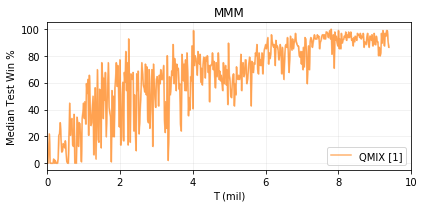

In [7]:
# plot results
color='C1'
band_alpha=0.3
line_alpha=0.6

test_interval = experiments[0].config['test_interval']
x = np.arange(res.shape[0]) * test_interval / 1e6

plt.figure(figsize=(6, 3))
plt.plot(x, median, color=color, alpha=line_alpha, label=f"QMIX [{res.shape[1]}]")
plt.fill_between(x, percentiles[:, 1], percentiles[:, 0], color=color, alpha=band_alpha)
plt.xlabel('T (mil)')
plt.ylabel('Median Test Win %')
plt.title('MMM')
plt.legend(loc='lower right')
plt.xlim((0, 10))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('img/results.png')